In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})

from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi,residual

<img src="img/FDMexample.png">

# Perform Gauss-Seidel algorithm

In [7]:
# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L = 1   # length
M = np.zeros((Nx,Ny)) # an empty matrix
S = np.zeros((Nx,Ny))
phi = np.zeros((Nx,Ny))

dx = L/(Nx-1)    # Grid size
dy = L/(Ny-1)    # Grid size

tol = 1e-6
aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)

phi, S = prepare_phi_and_S(Nx, Ny, phi, L)

for _ in tqdm(range(10000)):

    for i in range(1,Nx-1):
        for j in range(1,Ny-1):

            # Gauss-Siedel Update
            phi[i,j] = (S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1]) / a0

    # Calculate residual
    R2 = 0
    R = np.zeros((Nx,Ny))

    for i in range(1,Nx-1):    
        for j in range(1,Ny-1):
            R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
            R2 = R2+R[i,j]**2

    R2 = np.sqrt(R2)
    if _ %500==0:
        clear_output(True)
        print('Residual:', R2)
        
    if R2<tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break


 30%|███       | 3026/10000 [00:14<00:33, 207.93it/s]

Residual: 1.2329210213311063e-05


 34%|███▍      | 3407/10000 [00:16<00:32, 203.95it/s]

Converged! Residual:  9.988058240720717e-07 Time elapsed:  16.722319841384888


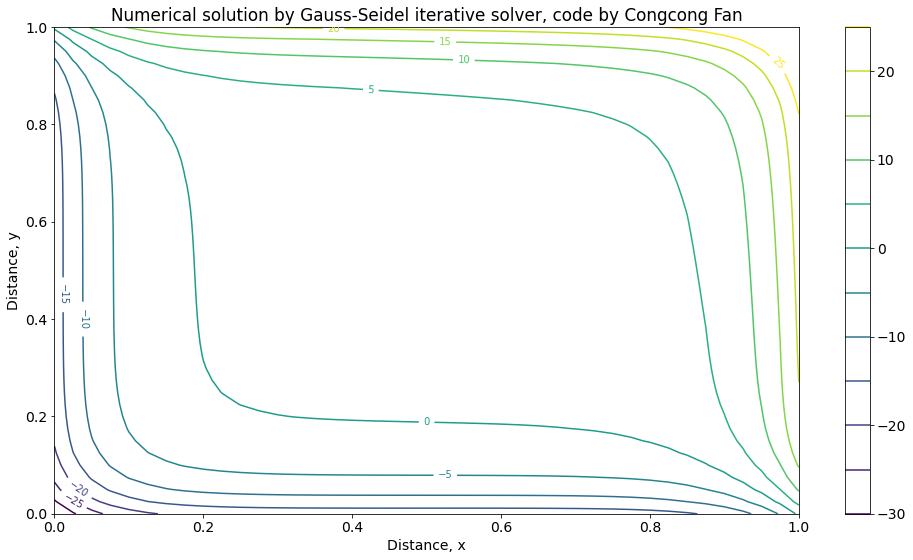

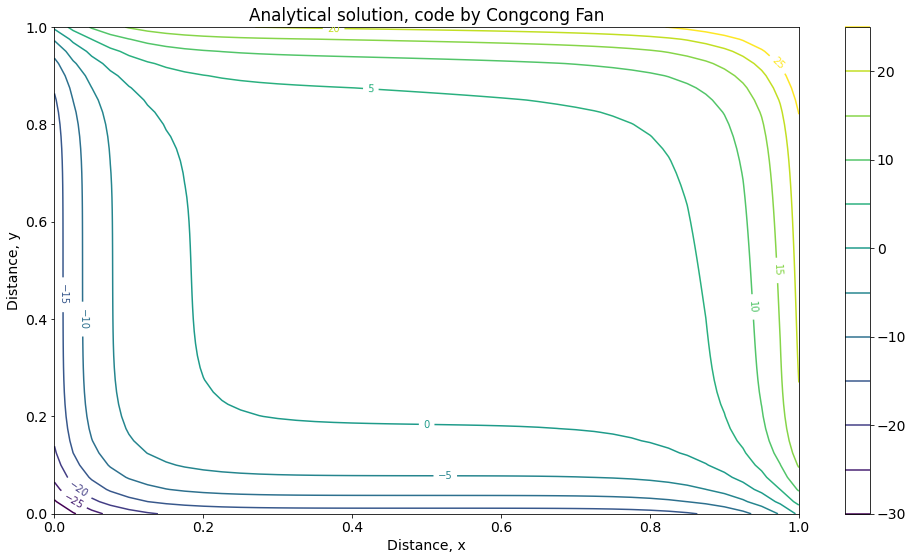

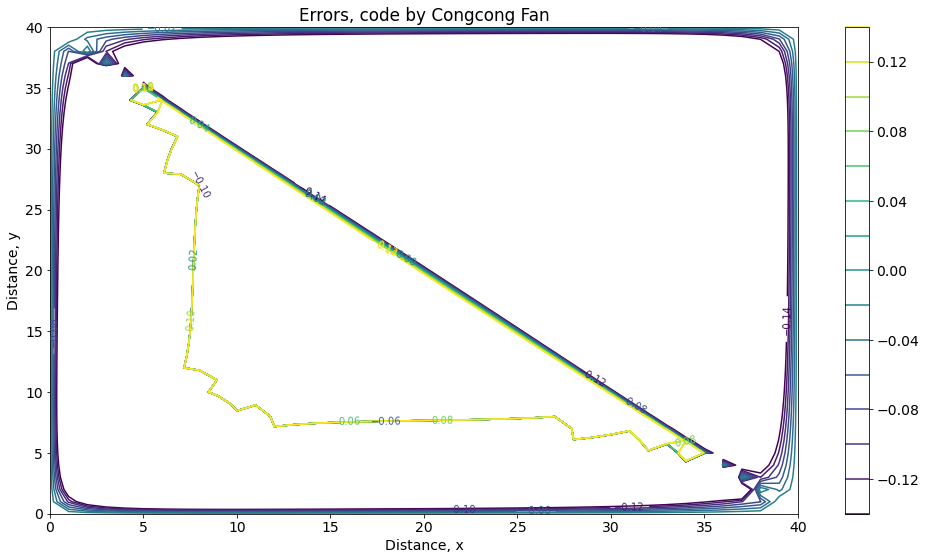

In [8]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx, Ny, 'Gauss-Seidel', convert=False)






# Alternating Direction Implicit (ADI) Line-by-line method, row-wise then column-wise. 
e.g. solve at constant i direction then march in j direction. Then in same loop, solve at constant j then march in i 

In [9]:
N=10
for i in range(N-2,-1,-1):
    print(i)

8
7
6
5
4
3
2
1
0


In [2]:
def TRI(N,a,d,c,Q):
    '''
    ┌                                        ┐
    │  d1  c1  0 ...                        0│
    │  a1  d2  c2  0 ...                    0│
    │        .                               │
    │          .                             │
    │            .                           │┌     ┐  ┌     ┐
    │... 0   ai-2  di-1  ci-1 0  ...         ││Phi_x│= | Q_x |
    │                  .                     │└     ┘  └     ┘
    │                   .                    │
    │                    .                   │
    │0     ... 0   aN-2  dN-1  cN-1  0  ...  │
    │0         ... 0   aN-1  dN    0  ...    │ 
    └                                        ┘
    '''
    # Tridiagonal matrix solver
    phi = np.zeros(N)

    # Forward Elemination
    for i in range (1,N):
        const = a[i-1] / d[i-1]
        d[i] = d[i] - const*c[i-1] # Diagonal
        Q[i] = Q[i] - const*Q[i-1]  # RHS
    
    # Solve last equation 
    phi[-1] = Q[-1]/d[-1]

    # Qackward Elemination
    for i in range(N-2,-1,-1):
        
        phi[i] = (Q[i] - c[i]*phi[i+1]) / d[i]

    return phi

In [4]:
# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L = 1   # length
M = np.zeros((Nx,Ny)) # an empty matrix
phi = np.zeros((Nx,Ny))
S = np.zeros((Nx,Ny))

dx = L/(Nx-1)    # Grid size
dy = L/(Ny-1)    # Grid size

tol = 1e-6

aE = 1/dx**2
aW = 1/dx**2
aN = 1/dy**2
aS = 1/dy**2
a0 = -(2/dx**2 + 2/dy**2)

phi, S = prepare_phi_and_S(Nx, Ny, phi, L)

    
for _ in tqdm(range(100000)):
    
    c = np.zeros(Nx-1)
    a = np.zeros(Nx-1)
    d = np.zeros(Nx)
    Q = np.zeros(Nx)
    for j in range(1,Ny-1):

        # For Dirichlet BC
        d[0] = 1

        # Left BC
        Q[0] = phi[0,j]

        for i in range(1,Nx-1):
            # Coefficient for Tridiagonal matrix solver
            d[i] = a0
            a[i-1] = aW
            c[i] = aE
            
            # RHS for Tri matrix
            Q[i] = S[i,j] - phi[i,j+1]*aN - phi[i,j-1]*aS

        # For Dirichlet BC
        d[Nx-1]=1
        
        # Right BC
        Q[Nx-1] = phi[-1,j]
        
        # Solve for current row
        phix = TRI(Nx,a,d,c,Q)

        # Update current new row solution
        phi[:,j] = phix
    
    # Column-wise sweep
    c = np.zeros(Ny-1)
    a = np.zeros(Ny-1)
    d = np.zeros(Ny)
    Q = np.zeros(Ny)
    for i in range(1,Nx-1):

        # For Dirichlet BC
        d[0] = 1

        # Bottom BC
        Q[0] = phi[i,0]

        for j in range(1,Ny-1):
            x = i*dx
            y = j*dy

            # Coefficient for Tridiagonal matrix solver
            d[j] = a0
            a[j-1] = aN
            c[j] = aS

            # RHS for Tri matrix
            Q[j] = S[i,j] - phi[i+1,j]*aE - phi[i-1,j]*aW


        # For Dirichlet BC
        d[Ny-1]=1
        
        # Top BC
        Q[Ny-1] = phi[i,Ny-1]
        
        # Solve for current row
        phix = TRI(Ny,a,d,c,Q)

        # Update current new row solution
        phi[i,:] = phix
        
    # Calculate residual
    R2 = 0
    R = np.zeros((Nx,Ny))

    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
            R2 = R2+R[i,j]**2

    R2 = np.sqrt(R2)
    if _ %50==0:
        clear_output(True)
        print("Residual: ",R2)
        
    if R2<tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break



  0%|          | 369/100000 [00:03<17:20, 95.77it/s]

Residual:  0.25013225331550865


  0%|          | 387/100000 [00:04<17:33, 94.59it/s]


KeyboardInterrupt: 

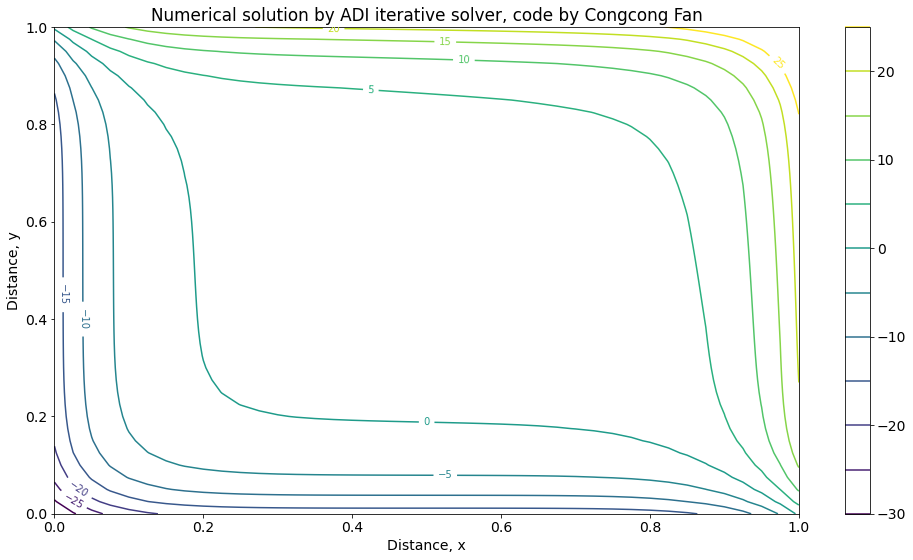

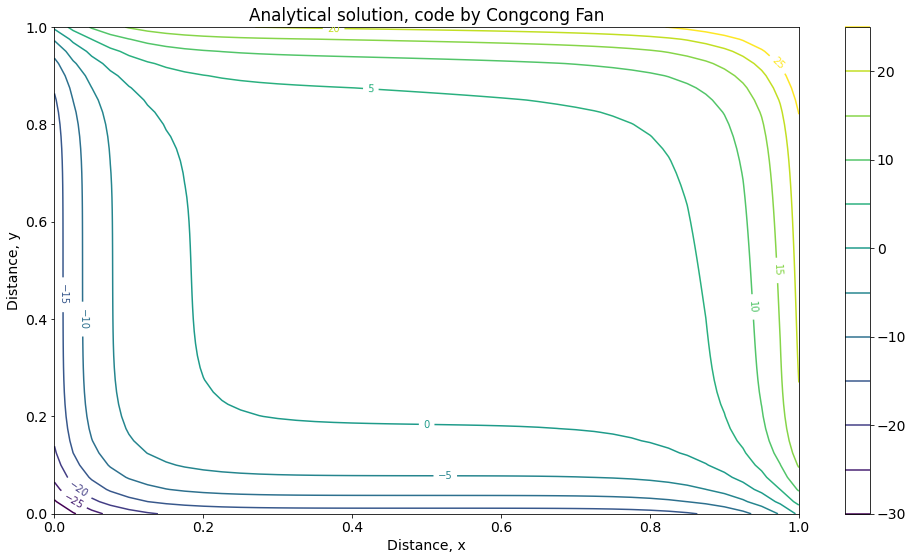

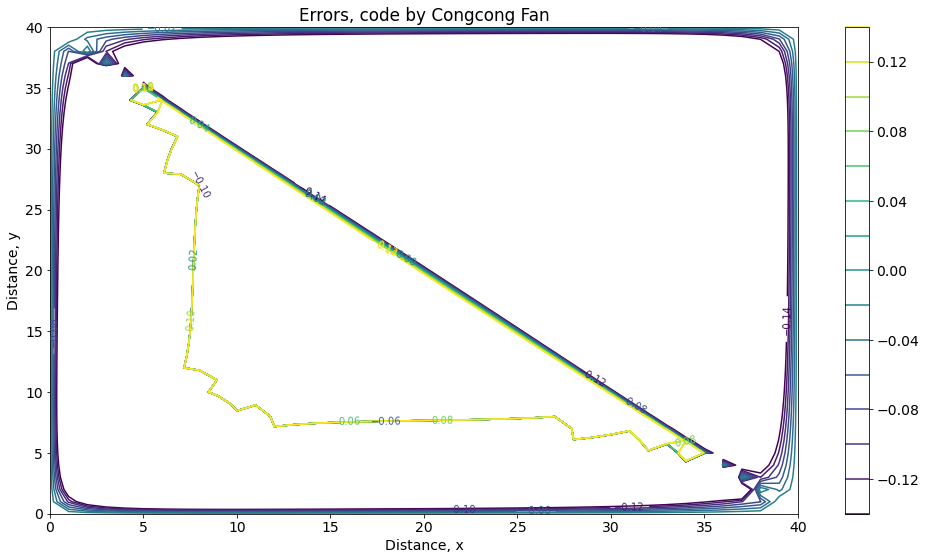

In [12]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx, Ny, 'ADI', convert=False)






# Stone's strongly implicit method
<img src="img/stones implicit method.png">
<img src="img/stones code snippet.png">

In [1]:
def stonesmethod(N, K, B, D, E, F, H):
    d, e, c, b, f = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)
    # Bbar,Cbar,Dbar,Ebar,Fbar,Gbar,Hbar = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    alpha = 0.8

    # Step 3
    d[0] = E[0]
    e[0] = F[0] / d[0]
    f[0] = H[0] / d[0]

    for k in range(1, K):
        if k > N:
            b[k] = B[k] / (1 + alpha * e[k - N])
        # print(k, K, c.shape)
        c[k] = D[k] / (1 + alpha * f[k - 1])

        if k > N:
            d[k] = E[k] + alpha * (b[k] * e[k - N] + c[k] * f[k - 1]) - b[k] * f[k - N] - c[k] * e[k - 1]
        else:
            d[k] = E[k] + alpha * (c[k] * f[k - 1]) - c[k] * e[k - 1]

        f[k] = (H[k] - alpha * c[k] * f[k - 1]) / d[k]

        if k > N:
            e[k] = (F[k] - alpha * b[k] * e[k - N]) / d[k]

        else:
            e[k] = F[k] / d[k]

    return b, c, d, e, f

In [2]:
def matrixA(Nx,Ny):
    A = np.zeros((Nx ** 2, Ny ** 2))

    ## Right BC
    i = Nx - 1
    for j in range(Ny):
        x = i * dx
        y = j * dy

        k = (j - 1) * Ny + i
        A[k, k] = 1

    ## left BC
    i = 0
    for j in range(Ny):
        x = i * dx
        y = j * dy
        k = (j - 1) * Ny + i
        A[k, k] = 1
    ## Bottom BC
    j = 0
    for i in range(Nx):
        x = i * dx
        y = j * dy
        k = (j - 1) * Ny + i
        A[k, k] = 1
    ## Top BC
    j = Ny - 1
    for i in range(Nx):
        x = i * dx
        y = j * dy
        k = (j - 1) * Ny + i
        A[k, k] = 1

    for i in range(1, Nx - 1):

        for j in range(1, Ny - 1):
            k = (j - 1) * Ny + i
            A[k, k] = -2 / dx ** 2 - 2 / dy ** 2
            A[k, k - 1] = 1 / dx ** 2
            A[k, k + 1] = 1 / dx ** 2

            A[k, k - N] = 1 / dy ** 2
            A[k, k + N] = 1 / dy ** 2

    return A

In [4]:
from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
start = time.time()
Nx = 41
Ny = 41
L = 1  # length
H = 1  # height
phi = np.zeros((Nx*Ny))
S = np.zeros((Nx*Ny))

dx = L / (Nx - 1)  # Grid size
dy = L / (Ny - 1)  # Grid size

tol = 1e-6

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)

phi, S = prepare_phi_and_S(Nx,Ny,phi,L,H,convert_to_K=True)

L = np.zeros((Nx ** 2, Ny ** 2))
U = np.zeros((Nx ** 2, Ny ** 2))



## Right BC
i = Nx - 1
for j in range(1,Ny-1):
    k = (j - 1) * Nx + i
    L[k, k] = 1
    U[k, k] = 1

## left BC
i = 0
for j in range(1,Ny-1):
    k = (j - 1) * Nx + i
    L[k, k] = 1
    U[k, k] = 1
## Bottom BC
j = 0
for i in range(Nx):
    k = (j - 1) * Nx + i
    L[k, k] = 1
    U[k, k] = 1
## Top BC
j = Ny - 1
for i in range(Nx):
    k = (j - 1) * Nx + i
    L[k, k] = 1
    U[k, k] = 1

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)


# Step 
K = Nx*Ny
B = np.full(K, aS)
D = np.full(K, aW)
E = np.full(K, a0)
F = np.full(K, aE)
H = np.full(K, aN)

s = time.time()
for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
        k = (j - 1) * Nx + i
        b, c, d, e, f = stonesmethod(Nx, k, B, D, E, F, H)

        # print(k)

        L[k, k] = d[k-1]
        L[k, k - 1] = c[k-1]
        L[k, k - Nx] = b[k-1]

        U[k, k] = 1
        U[k, k + 1] = e[k-1]
        U[k, k + Nx] = f[k-1]

R2 = 0
R = np.zeros(Nx*Ny)


for _ in tqdm(range(100000)):
    # Step 4
    # Calculate residual
    R2 = 0
    for i in range(1, Nx - 1):

        for j in range(1, Ny - 1):
            x = i * dx
            y = j * dy
            k = (j - 1) * Nx + i
            R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

            R2 = R2 + R[k] ** 2

# Another way to calculate residual, same as above, but memory inefficient.
# Basically constructed whole A matrix and multiply with phi

# A = matrixA(N)
# for _ in tqdm(range(100000)):
#     # Step 4
#     # Calculate residual
#     R2 = 0
#     s = time.time()
#     R = S-np.matmul(A,phi)
    
#     for i in range(1, N - 1):

#         for j in range(1, N - 1):
#             x = i * dx
#             y = j * dy
#             k = (j - 1) * N + i
#             R2 = R2 + R[k] ** 2

    # Step 5
    Y = np.matmul(np.linalg.inv(L),R)

    # Step 6
    delta = np.matmul(np.linalg.inv(U) , Y)

    phi += delta
    # print(delta)
    R2 = np.sqrt(R2)
    if _ % 10 == 0:
        clear_output(True)
        print("Residual: ", R2)

    if R2 < tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break

  0%|          | 11/100000 [00:02<5:39:57,  4.90it/s]

Residual:  1346.7444984442702


  0%|          | 17/100000 [00:03<6:21:02,  4.37it/s]


KeyboardInterrupt: 

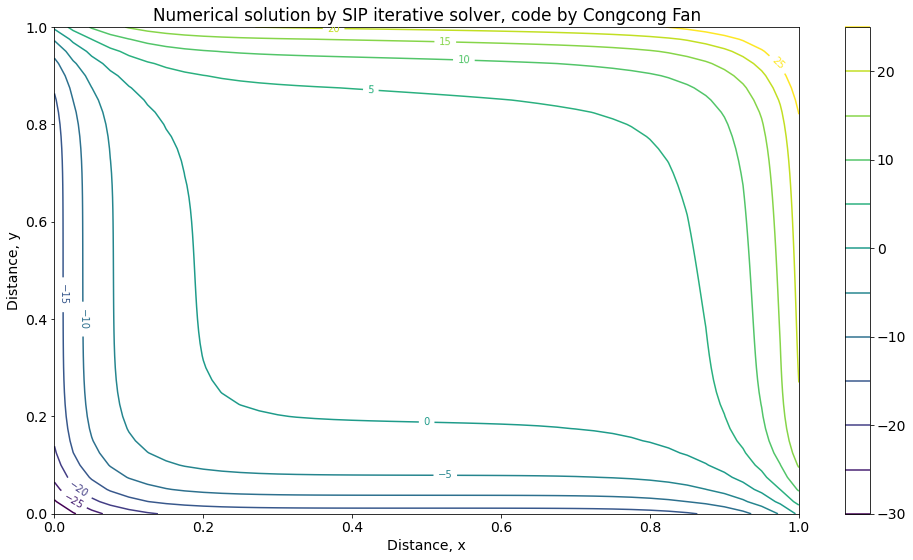

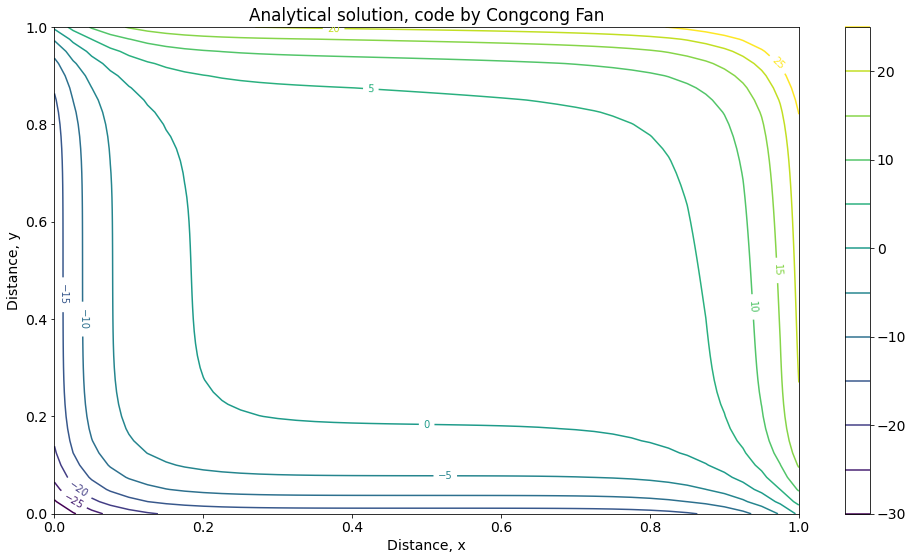

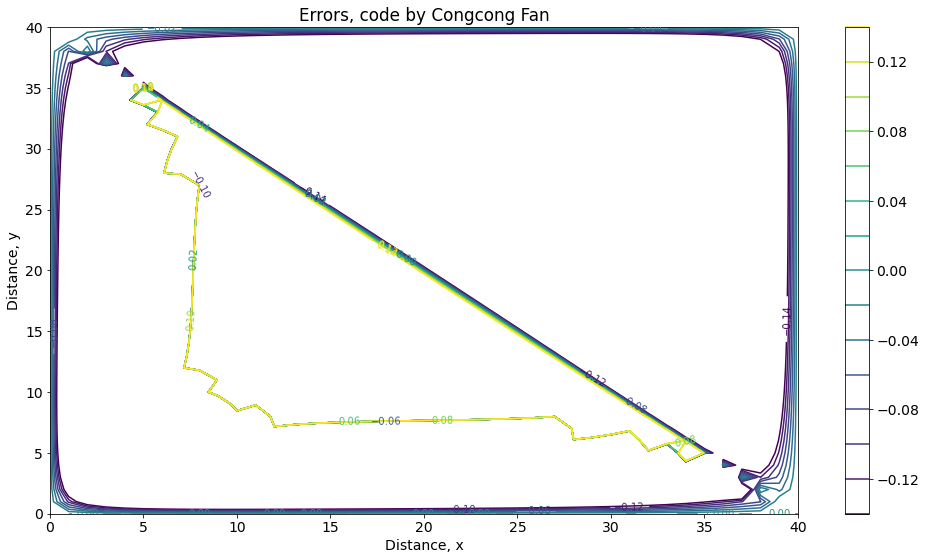

In [16]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx, Ny, 'SIP', convert=True)






# Method of Steepest Descent MSD
It is slow but it is a foundation of other iterative solver: CG, CGS
<img src="MSD.png">

In [17]:
start = time.time()
N = 41
M = 41
L = 1  # length
phi = np.zeros((N ** 2))
S = np.zeros((N ** 2))
R = np.zeros((N ** 2))

dx = L / (N - 1)  # Grid size
dy = L / (M - 1)  # Grid size

tol = 1e-6

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)

phi, S = prepare_phi_and_S(N,M,phi,L,convert_to_K=True)

# Same coefficient name as Stone's method
K = Nx*Ny
B = np.full(K, aS)
D = np.full(K, aW)
E = np.full(K, a0)
F = np.full(K, aE)
H = np.full(K, aN)


A = matrixA(N,M)

for _ in tqdm(range(100000)):
    # Step 4
    # Calculate residual
    R2sum = 0
    R = np.zeros((Nx,Ny))
    for i in range(1, Nx - 1):

        for j in range(1, Ny - 1):
            x = i * dx
            y = j * dy
            k = (j - 1) * Nx + i
            R[k] = S[k] - aE * phi[k + 1] - aW * phi[k - 1] - aN * phi[k + Nx] - aS * phi[k - Nx] - a0 * phi[k]

            R2sum = R2sum + R[k] ** 2
            
    R2 = np.sqrt(R2sum)

    c = np.zeros(N**2)

    for i in range(1, N - 1):
        for j in range(1, M - 1):
            K = (j - 1) * N + i
            k = K-1
            
            c[k] = E[k]*R[k] + F[k]*R[k+1] + H[k]*R[k+N] + D[k]*R[k-1] + B[k]*R[k-N]

    rtc = 0

    for k in range(N**2):
        rtc = rtc + R[k]*c[k]
    
    alpha = R2sum/rtc

    phi = phi + alpha*R
    

    if _ % 1000 == 0:
        clear_output(True)
        print(f'alpha: {alpha}')
        print("Residual: ", R2)

    if R2 < tol:
        print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
        break

  6%|▌         | 6047/100000 [00:34<08:57, 174.95it/s]

alpha: -0.00015625055700518365
Residual:  1.4010278619907309e-05


  7%|▋         | 6855/100000 [00:39<08:57, 173.45it/s]

Converged! Residual:  9.998734238927122e-07 Time elapsed:  39.53983211517334


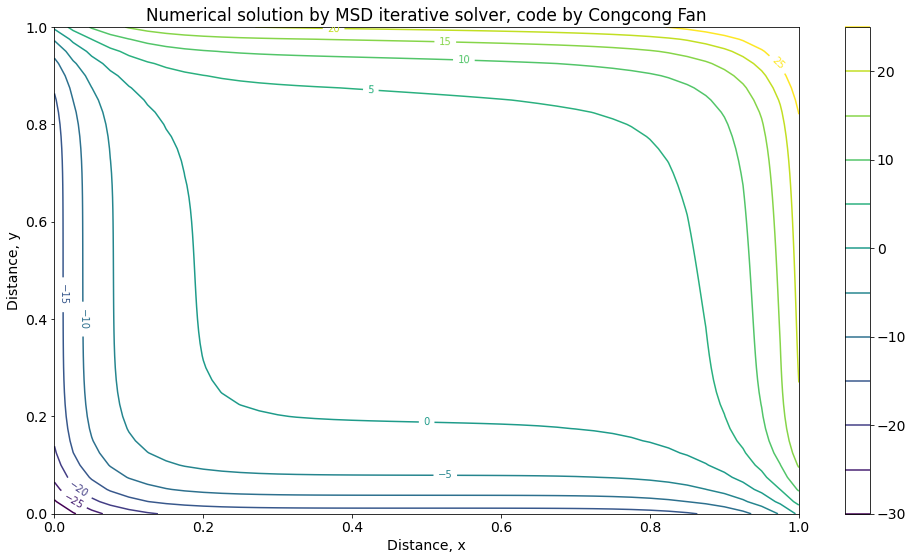

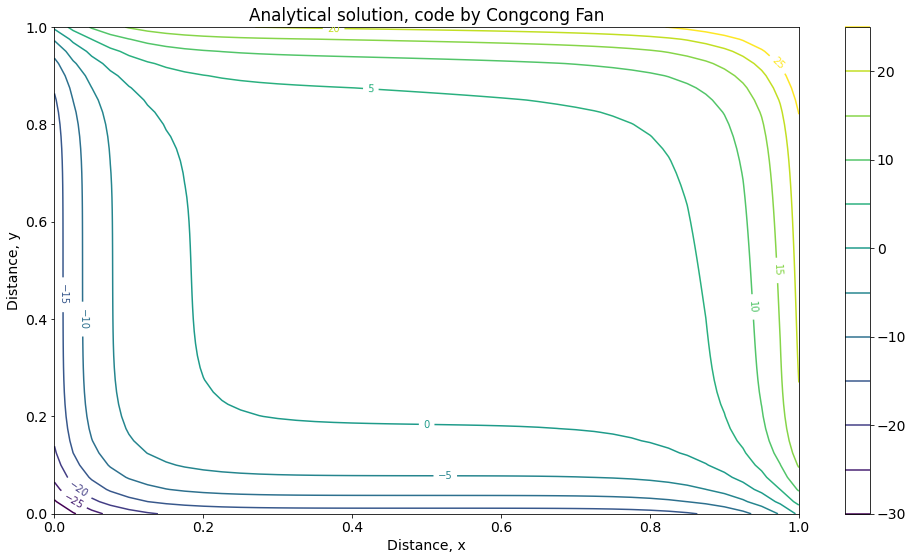

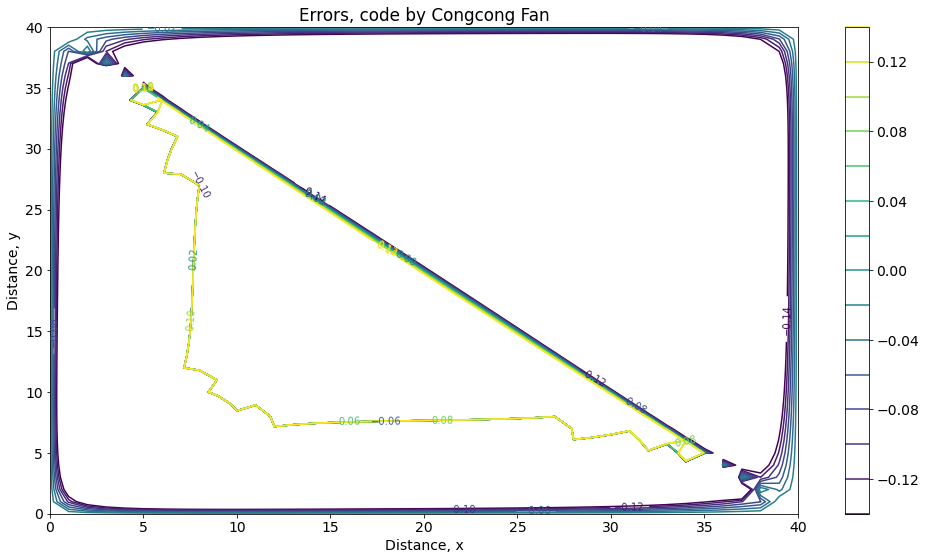

In [18]:
# Analytical solution
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
phi_A = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, N,N, 'MSD', convert=True)

# CG method

In [19]:
start = time.time()
N = 41
M = 41
L = 1  # length
phi = np.zeros((N*M))
S = np.zeros((N*M))

dx = L / (N - 1)  # Grid size
dy = L / (M - 1)  # Grid size

tol = 1e-6

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)

phi, S = prepare_phi_and_S(N,M,phi,L,convert_to_K=True)

A = matrixA(N,M)

# Initial residual
R = S - A@phi
R2sum_old = 0 
for i in range(N):

    for j in range(M):
        k = (j - 1) * N + i
        R2sum_old = R2sum_old + R[k] ** 2
    
R2_old = np.sqrt(R2sum_old)
# Step 3: Set the initial search direction vector equal to the residual vector
D = R

for _ in tqdm(range(100000)):

    # Compute new alpha
    
    
    alpha_new = R.T @ R / (D.T @ A @ D)


    phi = phi + alpha_new*D
    
    # Compute residual
    R2sum_new, R = residual(N,M,phi,S,aE,aW,aN,aS,a0)

    R2_new = np.sqrt(R2sum_new)

    beta = R2_new**2 / R2_old**2

    # Update search direction vector
    D = R + beta*D
    

    # Update old residual vector
    R2_old = R2_new
    
    if _ % 100 == 0:
        clear_output(True)
        print(f'alpha: {alpha}')
        print("Residual: ", R2_new)

    if R2_new < tol:
        print('Converged! Residual: ',R2_new, 'Time elapsed: ', time.time()-start)
        break

  0%|          | 147/100000 [00:00<04:48, 346.54it/s]

alpha: -0.0001563042553218626
Residual:  0.2648136921401258
Converged! Residual:  7.52811495486506e-07 Time elapsed:  0.4489479064941406


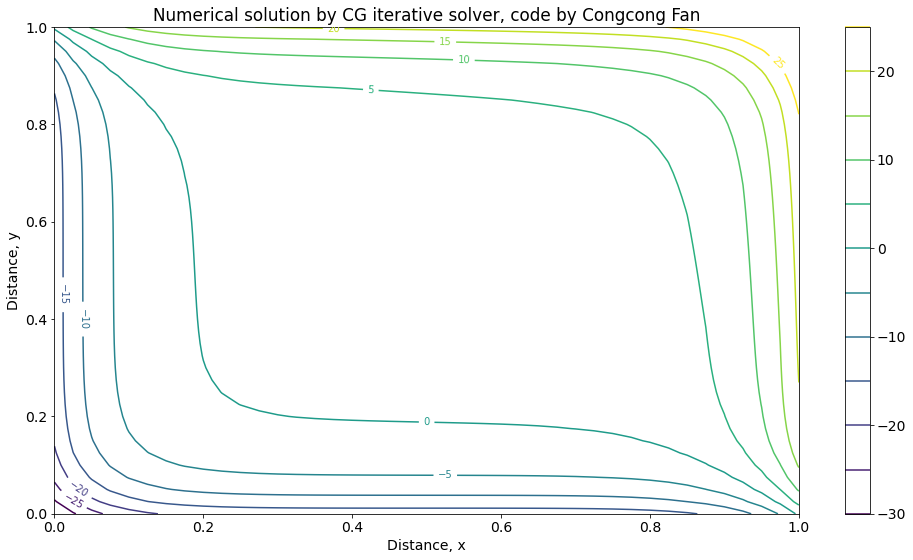

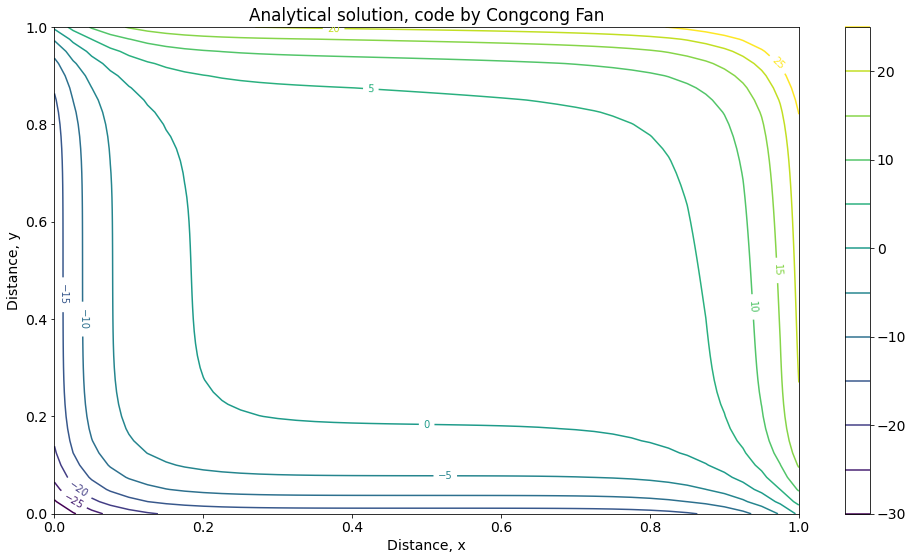

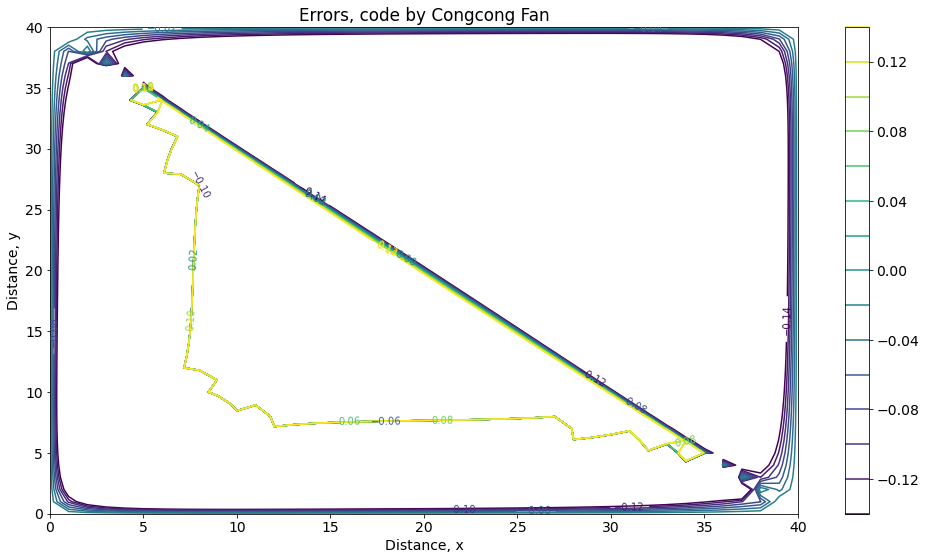

In [20]:
# Analytical solution
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
phi_A = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, N,N, 'CG', convert=True)

# CGS 

In [33]:
start = time.time()
Nx = 41
Ny = 41
L = 1  # length
phi = np.zeros((Nx*Ny))
S = np.zeros((Nx*Ny))

dx = L / (Nx - 1)  # Grid size
dy = L / (Ny - 1)  # Grid size

tol = 1e-8

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)

# Same coefficient name as Stone's method
K = Nx*Ny
B = np.full(K, aS)
D = np.full(K, aW)
E = np.full(K, a0)
F = np.full(K, aE)
H = np.full(K, aN)

phi, S = prepare_phi_and_S(Nx,Ny,phi,L,convert_to_K=True)



# Initial residual
R2sum_old,R0 = residual(Nx,Ny, phi,S,aE,aW,aN,aS,a0)

# Step 3: Set the initial search direction vector equal to the residual vector
D0 = R0
D_conjugate = R0
R_old = R0
for _ in tqdm(range(100000)):

    # Compute new alpha = R0.T @ R_old / (R0.T @ A @ D)
    
    # Compute A@D
    ad = np.zeros(Nx*Ny)
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            k = (j - 1) * Nx + i
            # k = K-1
            
            ad[k] = E[k]*D0[k] + F[k]*D0[k+1] + H[k]*D0[k+Nx] + D[k]*D0[k-1] + B[k]*D0[k-Nx]
    
    # Compute R0.T @ A @ D
    r_t_ad = 0
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):

            k = (j - 1) * Nx + i
            r_t_ad = r_t_ad + R0[k]*ad[k]
    

    
    alpha = R0.T @ R_old / r_t_ad

    G = D_conjugate - alpha * ad


    phi = phi + alpha*(D_conjugate + G)
    
    # Compute residual

    R2sum_new, R_new = residual(Nx,Ny, phi,S,aE,aW,aN,aS,a0)    

    R2_new = np.sqrt(R2sum_new)
    
    beta = R0.T @ R_new / (R0.T @ R_old)

    # Update search direction vector
    D_conjugate = R_new + beta*G
    

    # Update old residual vector
    R2_old = R2_new
    R_old = R_new

    # Update search direction vector
    D0 = D_conjugate + beta* (G + beta*D0)
    
    if _ % 100 == 0:
        clear_output(True)
        print(f'alpha: {alpha}')
        print("Residual: ", R2_new)

    if R2_new < tol:
        print('Converged! Residual: ',R2_new, 'Time elapsed: ', time.time()-start)
        break

  0%|          | 118/100000 [00:00<09:24, 176.80it/s]

alpha: -0.00026510019358708055
Residual:  0.00022637748229616873
Converged! Residual:  1.060647586271822e-09 Time elapsed:  0.6844711303710938


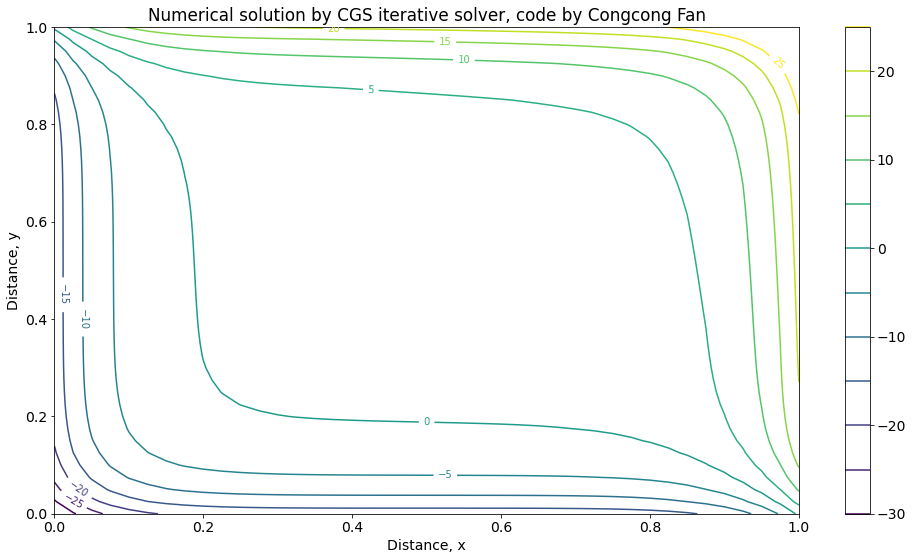

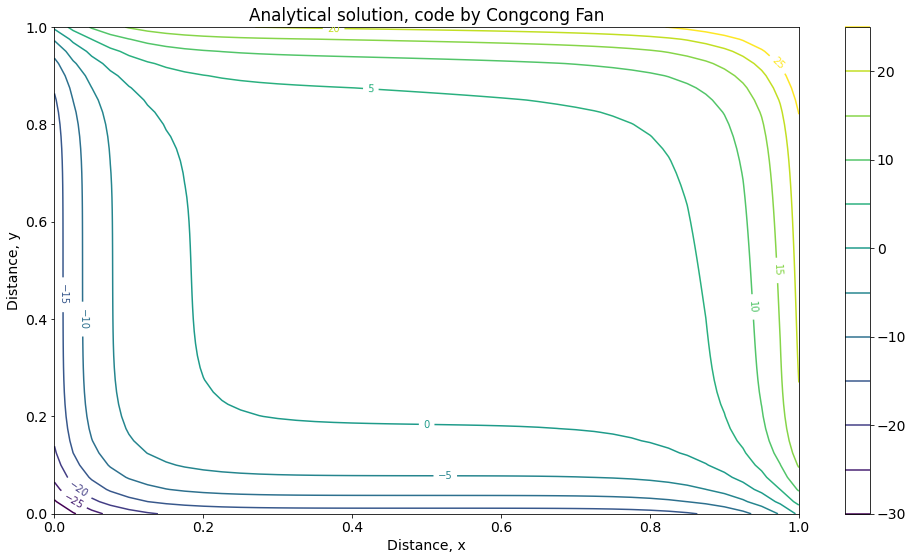

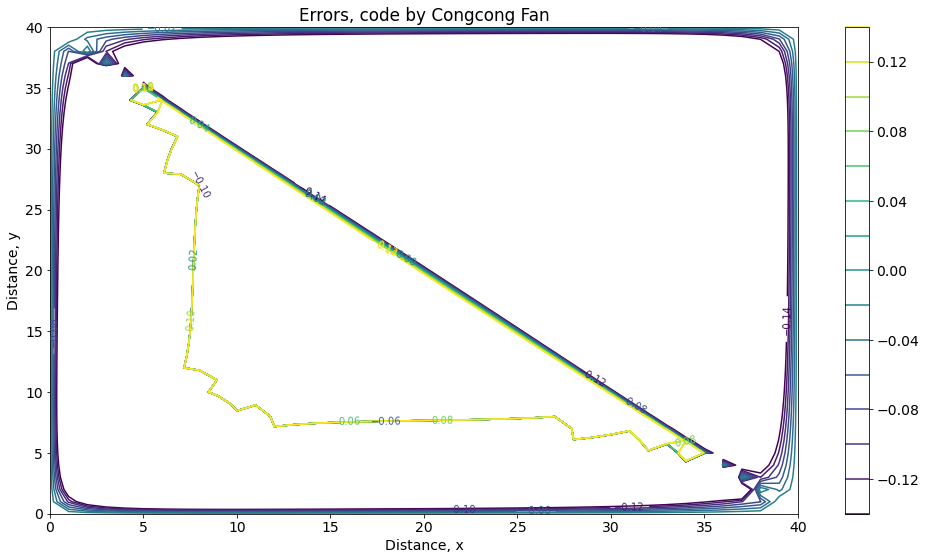

In [34]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = (x[i]-0.5)**2*np.sinh(10*(x[i]-0.5))+(y[j]-0.5)**2*np.sinh(10*(y[j]-0.5))+np.exp(2*x[i]*y[j])

plot_phi(phi, phi_A, Nx,Ny, 'CGS', convert=True)

In [23]:
phitext

NameError: name 'phitext' is not defined

In [ ]:
phi

array([-16.9617329 ,  -6.3277051 ,  -2.36377293, ..., -17.40572823,
       -17.31331225, -17.17266486])